# 1. Attractive Field = True

## Codes copied from learn_bp_map_marginal... to create datasets and models

In [1]:
import os
os.chdir('..')

import torch
from torch import autograd
import pickle
import wandb
import random

from nn_models import lbp_message_passing_network, GIN_Network_withEdgeFeatures
from ising_model.pytorch_dataset import build_factorgraph_from_SpinGlassModel
from ising_model.spin_glass_model import SpinGlassModel
from factor_graph import FactorGraphData
from factor_graph import DataLoader_custom as DataLoader_pytorchGeometric

from ising_model.pytorch_geometric_data import spinGlass_to_torchGeometric


import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import parameters
from parameters import ROOT_DIR, alpha, alpha2, SHARE_WEIGHTS, BETHE_MLP, NUM_MLPS
import cProfile

MODEL_MAP_FLAG = True
CLASSIFICATION_FLAG = True
TRAINING_FLAG = True
BETHE_MLP = True
ATTRACTIVE_FIELD = True
LEARNING_RATE = 1e-6
LR_DECAY_FLAG = False
ALPHA = alpha
ALPHA2 = alpha2
MSG_PASSING_ITERS = 50
SHARE_WEIGHTS = False


MODE = "train" #run "test" or "train" mode

TEST_TRAINED_MODEL = True 
EXPERIMENT_NAME = 'trained_MAP_attrField_10layer_2MLPs_noFinalBetheMLP/' #used for saving results when MODE='test'

USE_WANDB = False
####### Training PARAMETERS #######
MAX_FACTOR_STATE_DIMENSIONS = 2
EPSILON = 0 #set factor states with potential 0 to EPSILON for numerical stability
SHARE_WEIGHTS = True if not TRAINING_FLAG  else SHARE_WEIGHTS
MODEL_NAME = "MAP_spinGlass_%dlayer_alpha=%f.pth" % (MSG_PASSING_ITERS, parameters.alpha)
TRAINED_MODELS_DIR = ROOT_DIR + "trained_models_map/" #trained models are stored here

##########################################################################################################
N_MIN_TRAIN = 10
N_MAX_TRAIN = 10
F_MAX_TRAIN = .1
C_MAX_TRAIN = 5.0
ATTRACTIVE_FIELD_TRAIN = ATTRACTIVE_FIELD

N_MIN_VAL = 10
N_MAX_VAL = 10
F_MAX_VAL = .1
C_MAX_VAL = 5.0
ATTRACTIVE_FIELD_VAL = ATTRACTIVE_FIELD

REGENERATE_DATA = False
DATA_DIR = "./data/spin_glass_map/"

TRAINING_DATA_SIZE = 50
VAL_DATA_SIZE = 50#100
TEST_DATA_SIZE = 200

TRAIN_BATCH_SIZE=50
VAL_BATCH_SIZE=50

EPOCH_COUNT = 5000 if TRAINING_FLAG else 5
PRINT_FREQUENCY = 10 if TRAINING_FLAG else 1
VAL_FREQUENCY = 10 if TRAINING_FLAG else 1
SAVE_FREQUENCY = 100 if TRAINING_FLAG else 1

TEST_DATSET = 'val' 

##### Optimizer parameters #####
STEP_SIZE=(EPOCH_COUNT//4)
LR_DECAY=.5
if ATTRACTIVE_FIELD_TRAIN == True:
        LEARNING_RATE = LEARNING_RATE
else:
    LEARNING_RATE = LEARNING_RATE

def get_dataset(dataset_type):
    '''
    Store/load a list of SpinGlassModels
    When using, convert to BPNN or GNN form with either
    build_factorgraph_from_SpinGlassModel(pytorch_geometric=True) for BPNN or spinGlass_to_torchGeometric() for GNN
    '''
    assert(dataset_type in ['train', 'val', 'test'])
    if dataset_type == 'train':
        datasize = TRAINING_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_TRAIN
        N_MIN = N_MIN_TRAIN
        N_MAX = N_MAX_TRAIN
        F_MAX = F_MAX_TRAIN
        C_MAX = C_MAX_TRAIN
    elif dataset_type == 'val':
        datasize = VAL_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_VAL
        N_MIN = N_MIN_VAL
        N_MAX = N_MAX_VAL
        F_MAX = F_MAX_VAL
        C_MAX = C_MAX_VAL
    else:
        datasize = TEST_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_TEST

    dataset_file = DATA_DIR + dataset_type + '%d_%d_%d_%.2f_%.2f_attField=%s.pkl' % (datasize, N_MIN, N_MAX, F_MAX, C_MAX, ATTRACTIVE_FIELD)
    if REGENERATE_DATA or (not os.path.exists(dataset_file)):
        print("REGENERATING DATA!!")
        spin_glass_models_list = [SpinGlassModel(N=random.randint(N_MIN, N_MAX),\
                                                f=np.random.uniform(low=0, high=F_MAX),\
                                                c=np.random.uniform(low=0, high=C_MAX),\
                                                attractive_field=ATTRACTIVE_FIELD) for i in range(datasize)]
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
        with open(dataset_file, 'wb') as f:
            pickle.dump(spin_glass_models_list, f)
    else:
        with open(dataset_file, 'rb') as f:
            spin_glass_models_list = pickle.load(f)
    return spin_glass_models_list

device = torch.device('cpu')
lbp_net = lbp_message_passing_network(max_factor_state_dimensions=MAX_FACTOR_STATE_DIMENSIONS,\
                                      msg_passing_iters=MSG_PASSING_ITERS, device=None, bethe_MLP=BETHE_MLP,
                                      map_flag=MODEL_MAP_FLAG, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
                                      share_weights=SHARE_WEIGHTS,
                                      alpha=ALPHA, alpha2=ALPHA2)

lbp_net = lbp_net.to(device)

# lbp_net.double()
def cross_entropy_loss(x, y):
    return -torch.mean(torch.sum(y*torch.log(x+1e-30), dim=1))
def test_loss_func(x, y, sg_model):
    if CLASSIFICATION_FLAG:
        x = torch.log(x[:,0:-1]/x[:,-1:])
        y = torch.log(y[:,0:-1]/y[:,-1:])
    '''
    x, y of shape [N, 1] representing the difference of log marginals

    returning
    - mse_diff_log_loss, l1_diff_log_loss
    - mse_prob_loss, l1_prob_loss, cross_entropy_prob_loss, (where prob denotes
    the pseudo probabilities calculated from marginals)
    - var_state_accuracy, graph_state_accuracy, (where state denotes the
    maximum states calculated from marginals)
    - mse_logscore_state_loss, l1_logscore_state_loss, (where logscore
    represents the logScore of the maximum state calculated from marginals)
    '''
    diff_log = torch.abs(x-y).reshape(-1)
    mse_diff_log_loss = (diff_log**2).tolist()
    l1_diff_log_loss = diff_log.tolist()

    prob_x = torch.exp(x)/(torch.exp(x)+1)
    prob_x = torch.cat([prob_x, 1-prob_x], dim=-1)
    prob_y = torch.exp(y)/(torch.exp(y)+1)
    prob_y = torch.cat([prob_y, 1-prob_y], dim=-1)
    diff_prob = torch.abs(prob_x[:,0]-prob_y[:,0]).reshape(-1)
    mse_prob_loss = (diff_prob**2).tolist()
    l1_prob_loss = diff_prob.tolist()
    cross_entropy_prob_loss = (-torch.sum(prob_y*torch.log(prob_x+1e-30), dim=1)).tolist()

    state_x = (x<=0).float()
    state_y = (y<=0).float()
    accuracy = (state_x==state_y).float().reshape(-1)
    var_state_accuracy = accuracy.tolist()
    graph_state_accuracy = [torch.prod(accuracy).item()]

    score_x = sg_model.logScore(tuple(state_x.reshape(-1).tolist()))
    score_y = sg_model.logScore(tuple(state_y.reshape(-1).tolist()))
    diff_score = abs(score_x-score_y)
    mse_logscore_state_loss = [diff_score**2]
    l1_logscore_state_loss = [diff_score]

    return(
        mse_diff_log_loss, l1_diff_log_loss,
        mse_prob_loss, l1_prob_loss, cross_entropy_prob_loss,
        var_state_accuracy, graph_state_accuracy,
        mse_logscore_state_loss, l1_logscore_state_loss,
    )

learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True


In [3]:
lbp_net.train()
optimizer = torch.optim.Adam(lbp_net.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=LR_DECAY) #multiply lr by gamma every step_size epochs
loss_func = torch.nn.MSELoss() if not CLASSIFICATION_FLAG else cross_entropy_loss


spin_glass_models_list_train = get_dataset(dataset_type='train')
sg_models_fg_from_train = [build_factorgraph_from_SpinGlassModel(
    sg_model, map_flag=True, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
) for sg_model in spin_glass_models_list_train]
train_data_loader_pytorchGeometric = DataLoader_pytorchGeometric(sg_models_fg_from_train, batch_size=TRAIN_BATCH_SIZE, shuffle=False)


spin_glass_models_list_val = get_dataset(dataset_type='val')
sg_models_fg_from_val = [build_factorgraph_from_SpinGlassModel(
    sg_model, map_flag=True, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
) for sg_model in spin_glass_models_list_val]
val_data_loader_pytorchGeometric = DataLoader_pytorchGeometric(sg_models_fg_from_val, batch_size=VAL_BATCH_SIZE, shuffle=False)

## Statistics of True fake probabilities

In [4]:
for i, spin_glass_problem in enumerate(train_data_loader_pytorchGeometric):
    print(i, spin_glass_problem)
    exact_marginals_function = spin_glass_problem.marginals
    print(exact_marginals_function.shape)

0 Batch_custom(batch_factors=[14000], batch_vars=[5000], edge_index=[2, 23000], edge_var_indices=[2, 23000], facStates_to_varIdx=[92000], facToVar_edge_idx=[2, 23000], factor_degrees=[14000], factor_potential_masks=[14000, 2, 2], factor_potentials=[14000, 2, 2], marginals=[5000, 2], numFactors=[50], numVars=[50], prv_factorToVar_messages=[23000, 2], prv_factor_beliefs=[14000, 2, 2], prv_varToFactor_messages=[23000, 2], prv_var_beliefs=[5000, 2], state_dimensions=[50], varToFactorMsg_scatter_indices=[92000], var_degrees=[5000])
torch.Size([5000, 2])


(5000, 2)
5000


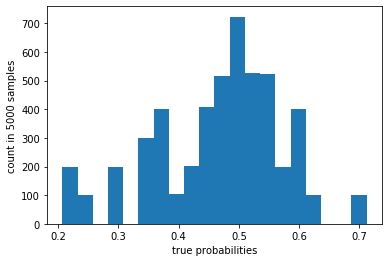

In [16]:
import matplotlib.pyplot as plt

true_prob = exact_marginals_function.detach().cpu().numpy()
print(true_prob.shape)
print(np.sum(np.absolute(np.sum(true_prob, axis=-1)-1)<1e-6))
plt.hist(true_prob[:,0],bins=20)
plt.xlabel('true probabilities')
plt.ylabel('count in 5000 samples')
plt.show()

## Plot of cross-entropy-losses

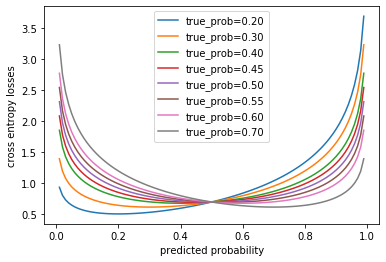

In [18]:
true_prob_list = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
pred_prob_list = np.linspace(0, 1, 102)[1:-1]
for tp in true_prob_list:
    closs = -tp*np.log(pred_prob_list)-(1-tp)*np.log(1-pred_prob_list)
    plt.plot(pred_prob_list, closs)
plt.xlabel('predicted probability')
plt.ylabel('cross entropy losses')
plt.legend(['true_prob=%.2f'%(tp) for tp in true_prob_list])
plt.show()

In [17]:
# minimum cross-entropy-loss
print(-np.mean(np.sum(true_prob*np.log(true_prob), axis=-1)))

0.66825265


# 1. Attractive Field = False

## Codes copied from learn_bp_map_marginal... to create datasets and models

In [1]:
import os
os.chdir('..')

import torch
from torch import autograd
import pickle
import wandb
import random

from nn_models import lbp_message_passing_network, GIN_Network_withEdgeFeatures
from ising_model.pytorch_dataset import build_factorgraph_from_SpinGlassModel
from ising_model.spin_glass_model import SpinGlassModel
from factor_graph import FactorGraphData
from factor_graph import DataLoader_custom as DataLoader_pytorchGeometric

from ising_model.pytorch_geometric_data import spinGlass_to_torchGeometric


import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import parameters
from parameters import ROOT_DIR, alpha, alpha2, SHARE_WEIGHTS, BETHE_MLP, NUM_MLPS
import cProfile

MODEL_MAP_FLAG = True
CLASSIFICATION_FLAG = True
TRAINING_FLAG = True
BETHE_MLP = True
ATTRACTIVE_FIELD = False
LEARNING_RATE = 1e-6
LR_DECAY_FLAG = False
ALPHA = alpha
ALPHA2 = alpha2
MSG_PASSING_ITERS = 50
SHARE_WEIGHTS = False


MODE = "train" #run "test" or "train" mode

TEST_TRAINED_MODEL = True 
EXPERIMENT_NAME = 'trained_MAP_attrField_10layer_2MLPs_noFinalBetheMLP/' #used for saving results when MODE='test'

USE_WANDB = False
####### Training PARAMETERS #######
MAX_FACTOR_STATE_DIMENSIONS = 2
EPSILON = 0 #set factor states with potential 0 to EPSILON for numerical stability
SHARE_WEIGHTS = True if not TRAINING_FLAG  else SHARE_WEIGHTS
MODEL_NAME = "MAP_spinGlass_%dlayer_alpha=%f.pth" % (MSG_PASSING_ITERS, parameters.alpha)
TRAINED_MODELS_DIR = ROOT_DIR + "trained_models_map/" #trained models are stored here

##########################################################################################################
N_MIN_TRAIN = 10
N_MAX_TRAIN = 10
F_MAX_TRAIN = .1
C_MAX_TRAIN = 5.0
ATTRACTIVE_FIELD_TRAIN = ATTRACTIVE_FIELD

N_MIN_VAL = 10
N_MAX_VAL = 10
F_MAX_VAL = .1
C_MAX_VAL = 5.0
ATTRACTIVE_FIELD_VAL = ATTRACTIVE_FIELD

REGENERATE_DATA = False
DATA_DIR = "./data/spin_glass_map/"

TRAINING_DATA_SIZE = 50
VAL_DATA_SIZE = 50#100
TEST_DATA_SIZE = 200

TRAIN_BATCH_SIZE=50
VAL_BATCH_SIZE=50

EPOCH_COUNT = 5000 if TRAINING_FLAG else 5
PRINT_FREQUENCY = 10 if TRAINING_FLAG else 1
VAL_FREQUENCY = 10 if TRAINING_FLAG else 1
SAVE_FREQUENCY = 100 if TRAINING_FLAG else 1

TEST_DATSET = 'val' 

##### Optimizer parameters #####
STEP_SIZE=(EPOCH_COUNT//4)
LR_DECAY=.5
if ATTRACTIVE_FIELD_TRAIN == True:
        LEARNING_RATE = LEARNING_RATE
else:
    LEARNING_RATE = LEARNING_RATE

def get_dataset(dataset_type):
    '''
    Store/load a list of SpinGlassModels
    When using, convert to BPNN or GNN form with either
    build_factorgraph_from_SpinGlassModel(pytorch_geometric=True) for BPNN or spinGlass_to_torchGeometric() for GNN
    '''
    assert(dataset_type in ['train', 'val', 'test'])
    if dataset_type == 'train':
        datasize = TRAINING_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_TRAIN
        N_MIN = N_MIN_TRAIN
        N_MAX = N_MAX_TRAIN
        F_MAX = F_MAX_TRAIN
        C_MAX = C_MAX_TRAIN
    elif dataset_type == 'val':
        datasize = VAL_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_VAL
        N_MIN = N_MIN_VAL
        N_MAX = N_MAX_VAL
        F_MAX = F_MAX_VAL
        C_MAX = C_MAX_VAL
    else:
        datasize = TEST_DATA_SIZE
        ATTRACTIVE_FIELD = ATTRACTIVE_FIELD_TEST

    dataset_file = DATA_DIR + dataset_type + '%d_%d_%d_%.2f_%.2f_attField=%s.pkl' % (datasize, N_MIN, N_MAX, F_MAX, C_MAX, ATTRACTIVE_FIELD)
    if REGENERATE_DATA or (not os.path.exists(dataset_file)):
        print("REGENERATING DATA!!")
        spin_glass_models_list = [SpinGlassModel(N=random.randint(N_MIN, N_MAX),\
                                                f=np.random.uniform(low=0, high=F_MAX),\
                                                c=np.random.uniform(low=0, high=C_MAX),\
                                                attractive_field=ATTRACTIVE_FIELD) for i in range(datasize)]
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
        with open(dataset_file, 'wb') as f:
            pickle.dump(spin_glass_models_list, f)
    else:
        with open(dataset_file, 'rb') as f:
            spin_glass_models_list = pickle.load(f)
    return spin_glass_models_list

device = torch.device('cpu')
lbp_net = lbp_message_passing_network(max_factor_state_dimensions=MAX_FACTOR_STATE_DIMENSIONS,\
                                      msg_passing_iters=MSG_PASSING_ITERS, device=None, bethe_MLP=BETHE_MLP,
                                      map_flag=MODEL_MAP_FLAG, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
                                      share_weights=SHARE_WEIGHTS,
                                      alpha=ALPHA, alpha2=ALPHA2)

lbp_net = lbp_net.to(device)

# lbp_net.double()
def cross_entropy_loss(x, y):
    return -torch.mean(torch.sum(y*torch.log(x+1e-30), dim=1))
def test_loss_func(x, y, sg_model):
    if CLASSIFICATION_FLAG:
        x = torch.log(x[:,0:-1]/x[:,-1:])
        y = torch.log(y[:,0:-1]/y[:,-1:])
    '''
    x, y of shape [N, 1] representing the difference of log marginals

    returning
    - mse_diff_log_loss, l1_diff_log_loss
    - mse_prob_loss, l1_prob_loss, cross_entropy_prob_loss, (where prob denotes
    the pseudo probabilities calculated from marginals)
    - var_state_accuracy, graph_state_accuracy, (where state denotes the
    maximum states calculated from marginals)
    - mse_logscore_state_loss, l1_logscore_state_loss, (where logscore
    represents the logScore of the maximum state calculated from marginals)
    '''
    diff_log = torch.abs(x-y).reshape(-1)
    mse_diff_log_loss = (diff_log**2).tolist()
    l1_diff_log_loss = diff_log.tolist()

    prob_x = torch.exp(x)/(torch.exp(x)+1)
    prob_x = torch.cat([prob_x, 1-prob_x], dim=-1)
    prob_y = torch.exp(y)/(torch.exp(y)+1)
    prob_y = torch.cat([prob_y, 1-prob_y], dim=-1)
    diff_prob = torch.abs(prob_x[:,0]-prob_y[:,0]).reshape(-1)
    mse_prob_loss = (diff_prob**2).tolist()
    l1_prob_loss = diff_prob.tolist()
    cross_entropy_prob_loss = (-torch.sum(prob_y*torch.log(prob_x+1e-30), dim=1)).tolist()

    state_x = (x<=0).float()
    state_y = (y<=0).float()
    accuracy = (state_x==state_y).float().reshape(-1)
    var_state_accuracy = accuracy.tolist()
    graph_state_accuracy = [torch.prod(accuracy).item()]

    score_x = sg_model.logScore(tuple(state_x.reshape(-1).tolist()))
    score_y = sg_model.logScore(tuple(state_y.reshape(-1).tolist()))
    diff_score = abs(score_x-score_y)
    mse_logscore_state_loss = [diff_score**2]
    l1_logscore_state_loss = [diff_score]

    return(
        mse_diff_log_loss, l1_diff_log_loss,
        mse_prob_loss, l1_prob_loss, cross_entropy_prob_loss,
        var_state_accuracy, graph_state_accuracy,
        mse_logscore_state_loss, l1_logscore_state_loss,
    )

learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True
learn_BP: True


In [2]:
lbp_net.train()
optimizer = torch.optim.Adam(lbp_net.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=LR_DECAY) #multiply lr by gamma every step_size epochs
loss_func = torch.nn.MSELoss() if not CLASSIFICATION_FLAG else cross_entropy_loss


spin_glass_models_list_train = get_dataset(dataset_type='train')
sg_models_fg_from_train = [build_factorgraph_from_SpinGlassModel(
    sg_model, map_flag=True, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
) for sg_model in spin_glass_models_list_train]
train_data_loader_pytorchGeometric = DataLoader_pytorchGeometric(sg_models_fg_from_train, batch_size=TRAIN_BATCH_SIZE, shuffle=False)


spin_glass_models_list_val = get_dataset(dataset_type='val')
sg_models_fg_from_val = [build_factorgraph_from_SpinGlassModel(
    sg_model, map_flag=True, marginal_flag=True, classification_flag=CLASSIFICATION_FLAG,
) for sg_model in spin_glass_models_list_val]
val_data_loader_pytorchGeometric = DataLoader_pytorchGeometric(sg_models_fg_from_val, batch_size=VAL_BATCH_SIZE, shuffle=False)

## Statistics of True fake probabilities

In [3]:
for i, spin_glass_problem in enumerate(train_data_loader_pytorchGeometric):
    print(i, spin_glass_problem)
    exact_marginals_function = spin_glass_problem.marginals
    print(exact_marginals_function.shape)

0 Batch_custom(batch_factors=[14000], batch_vars=[5000], edge_index=[2, 23000], edge_var_indices=[2, 23000], facStates_to_varIdx=[92000], facToVar_edge_idx=[2, 23000], factor_degrees=[14000], factor_potential_masks=[14000, 2, 2], factor_potentials=[14000, 2, 2], marginals=[5000, 2], numFactors=[50], numVars=[50], prv_factorToVar_messages=[23000, 2], prv_factor_beliefs=[14000, 2, 2], prv_varToFactor_messages=[23000, 2], prv_var_beliefs=[5000, 2], state_dimensions=[50], varToFactorMsg_scatter_indices=[92000], var_degrees=[5000])
torch.Size([5000, 2])


(5000, 2)
5000


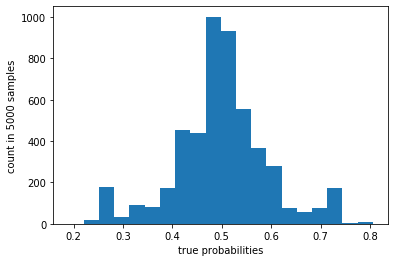

In [4]:
import matplotlib.pyplot as plt

true_prob = exact_marginals_function.detach().cpu().numpy()
print(true_prob.shape)
print(np.sum(np.absolute(np.sum(true_prob, axis=-1)-1)<1e-6))
plt.hist(true_prob[:,0],bins=20)
plt.xlabel('true probabilities')
plt.ylabel('count in 5000 samples')
plt.show()

## Plot of cross-entropy-losses

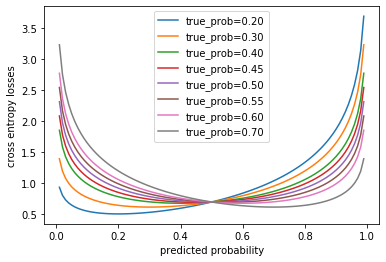

In [5]:
true_prob_list = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]
pred_prob_list = np.linspace(0, 1, 102)[1:-1]
for tp in true_prob_list:
    closs = -tp*np.log(pred_prob_list)-(1-tp)*np.log(1-pred_prob_list)
    plt.plot(pred_prob_list, closs)
plt.xlabel('predicted probability')
plt.ylabel('cross entropy losses')
plt.legend(['true_prob=%.2f'%(tp) for tp in true_prob_list])
plt.show()

In [6]:
# minimum cross-entropy-loss
print(-np.mean(np.sum(true_prob*np.log(true_prob), axis=-1)))

0.6742964


## Dataset Properties w.r.t. F, C

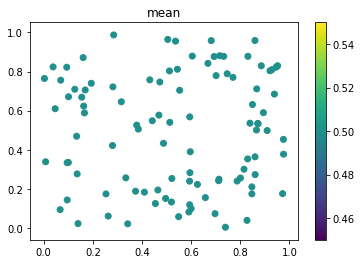

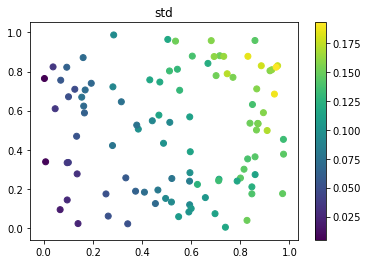

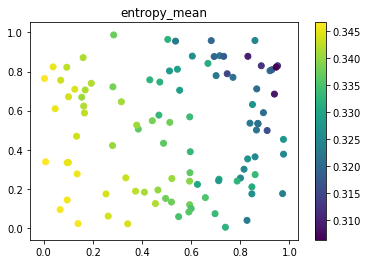

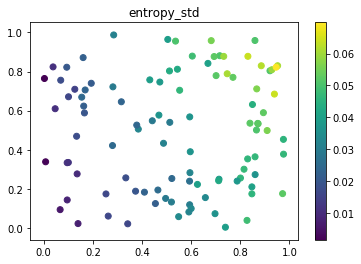

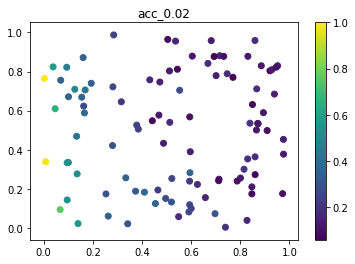

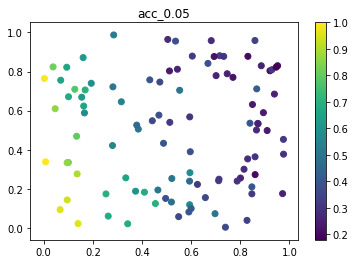

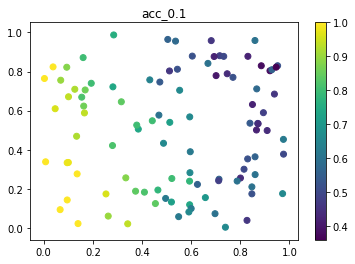

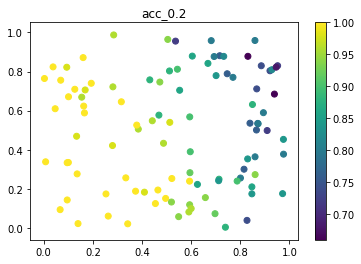

In [16]:
def FC2dataset(F, C, ):
    datasize = TRAINING_DATA_SIZE
    ATTRACTIVE_FIELD = False
    N_MIN = N_MIN_TRAIN
    N_MAX = N_MAX_TRAIN
    F_MAX = F
    C_MAX = C
    spin_glass_models_list = [SpinGlassModel(N=random.randint(N_MIN, N_MAX),\
                                            f=np.random.uniform(low=0, high=F_MAX),\
                                            c=np.random.uniform(low=0, high=C_MAX),\
                                            attractive_field=ATTRACTIVE_FIELD) for i in range(datasize)]
    return spin_glass_models_list
def dataset2prob(spin_glass_models_list):
    true_prob = np.array([sg_model.marginal_junction_tree_libdai(map_flag=True, classification_flag=True) 
                          for sg_model in spin_glass_models_list])
    return true_prob[:,0]
def prob2statistics(prob):
    return [
        np.mean(prob),
        np.std(prob),
        np.mean(-prob*np.log(prob)), #entropy
        np.std(-prob*np.log(prob)),
        np.mean((prob<0.52)*(prob>=0.48)),
        np.mean((prob<0.55)*(prob>=0.45)),
        np.mean((prob<0.6)*(prob>=0.4)),
        np.mean((prob<0.7)*(prob>=0.3)),
    ]
F_C_list = np.random.rand(100, 2)
datasets = [FC2dataset(F,C) for F,C in F_C_list]
probs = [dataset2prob(ds) for ds in datasets]
statistics = np.array([prob2statistics(p) for p in probs])
metric_name_list = [
    'mean',
    'std',
    'entropy_mean',
    'entropy_std',
    'acc_0.02',
    'acc_0.05',
    'acc_0.1',
    'acc_0.2',
]
for mi, mn in enumerate(metric_name_list):
    plt.scatter(F_C_list[:,0], F_C_list[:,1], c=statistics[:,mi])
    plt.colorbar()
    plt.title(mn)
    plt.show()